In [1]:
# use dream_proj_env conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf
import colorcet as cc
from lifelines import KaplanMeierFitter, CoxPHFitter
from statsmodels.stats.multitest import multipletests

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# create mapping of Organ to color
organ_palette = {
    "Liver": my_categorical_palette[1],
    "Kidney": my_categorical_palette[2],
    "Brain": my_categorical_palette[5],
}

# Read data

In [2]:
# Read lifespan data

# Load the data from the Excel file
file_path = "/cellar/users/zkoch/dream/data/williams_2022/aTableS1_AgingDB.xlsx"
survive_raw = pd.read_excel(file_path)

# select aniamls where the cause of death is natural or euth 
# and they are female
causes = ['Natural', 'Euthan']
survive = survive_raw.query("CauseOfDeath in @causes and Sex == 'F'").copy(deep = True)

# create indicator variable is death was observed
# this will be the inverse of AgeIfStillAlive2, which is 0 if the animal is still alive
survive['lifestatus'] = survive['AgeIfStillAlive2'].replace(0, 1)

/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
loader = read_data.DatasetLoader('williams_2022')
williams = loader.load_dataset()

# drop rows with 0 total seq depth (these were not profiled for expression)
williams.calc_total_seq_depth()
williams.expression_df = williams.expression_df.query('total_seq_depth > 0')

# calculate mean dream
williams.get_dream_gene_expression()
# invert mean_dream_expression and scale to be positive, to match direction of mean_dream_reg_expr_resid
williams.dream_expression['mean_dream_reg_expr'] = -1 * williams.dream_expression['mean_dream_reg_expr']
williams.dream_expression['mean_dream_reg_expr'] = williams.dream_expression['mean_dream_reg_expr'] - williams.dream_expression['mean_dream_reg_expr'].min()

williams.dream_enrichment_ssgsea()

# invert DREAM_normalized_enrichment_score and scale to be positive, to match direction of DREAM_normalized_enrichment_score
williams.dream_expression['DREAM_normalized_enrichment_score'] = -1 * williams.dream_expression['DREAM_normalized_enrichment_score']
williams.dream_expression['DREAM_normalized_enrichment_score'] = williams.dream_expression['DREAM_normalized_enrichment_score'] - williams.dream_expression['DREAM_normalized_enrichment_score'].min()

# create strain to glasbey dark mapping
strains = list(set(survive['StrainNameCurrent'].unique().tolist()).union(set(williams.dream_expression['Strain3'].unique())))
strain_palette = dict(zip(strains, cc.glasbey_dark[:len(strains)]))


In [4]:
# find strains with inconsistent dream expression
dream_std_by_strain = williams.dream_expression.groupby(['Strain3', 'Diet3'])['DREAM_normalized_enrichment_score_resid'].std().reset_index()
dream_std_by_strain.columns = ['Strain3', 'Diet3', 'std']
# add counts to this
counts = williams.dream_expression.groupby(['Strain3', 'Diet3']).size().reset_index()
counts.columns = ['Strain3', 'Diet3', 'count']
# comnbine
dream_std_by_strain = dream_std_by_strain.merge(counts, on = ['Strain3', 'Diet3'])
# drop strain-diet pairs with stdev > 0.2
high_std = dream_std_by_strain.query('std > .2') 

# drop strains from survive that have high dream std 
survive = survive.query('StrainNameCurrent not in @high_std["Strain3"]')
williams.dream_expression = williams.dream_expression.query('Strain3 not in @high_std["Strain3"]')
williams.expression_df = williams.expression_df.query('Strain3 not in @high_std["Strain3"]')

In [85]:
survive.shape

(612, 90)

In [84]:
williams.expression_df.shape

(270, 24775)

In [86]:
survive['StrainNameCurrent'].nunique()

40

In [87]:
williams.expression_df['Strain3'].nunique()

50

# Survival plots

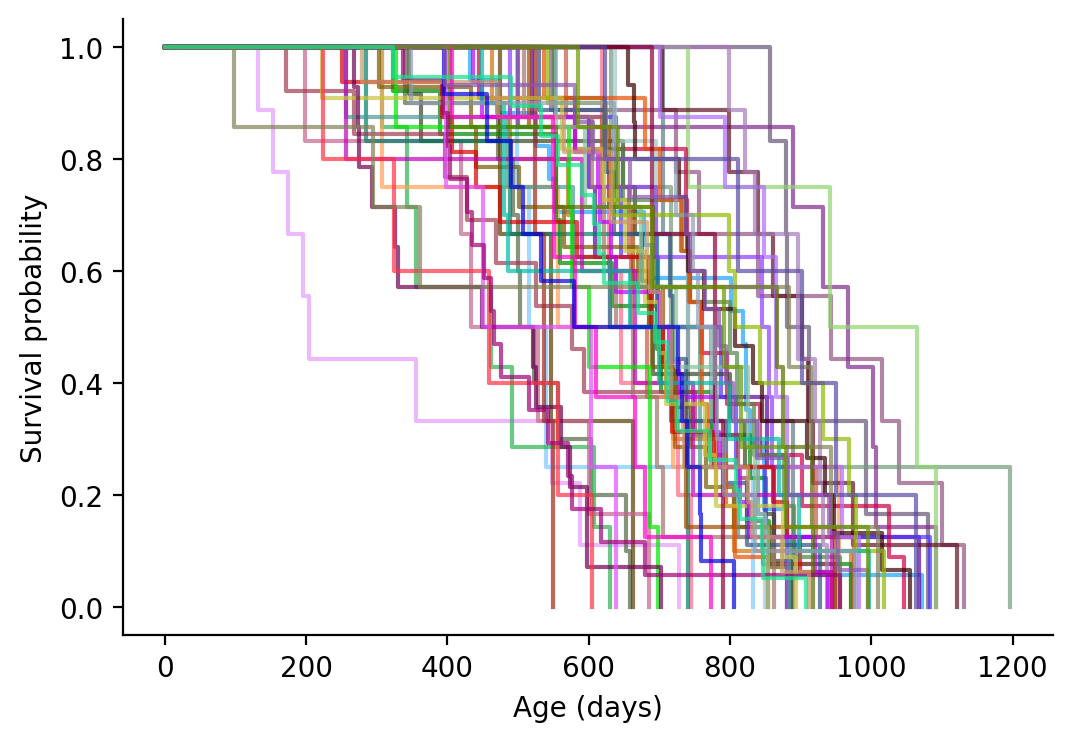

In [30]:
fig, axes = plt.subplots(1, 1, figsize = (6, 4))

# get count of individuals in strains
num_mice_per_strain = survive.query("DietCode == 'CD'").groupby('StrainNameCurrent').size()
# keep only strains with > 5 individuals
strains = num_mice_per_strain[num_mice_per_strain >= 3].index
strain_survival = {}
med_lifespans = {}
for i, strain in enumerate(strains):
    mask = survive.query("DietCode == 'CD'")['StrainNameCurrent'] == strain
    # Create a KaplanMeierFitter object
    this_strain_kmf = KaplanMeierFitter()
    this_strain_kmf.fit(
        durations = survive.query("DietCode == 'CD'")['AgeAtDeath'][mask],
        event_observed = survive.query("DietCode == 'CD'")['lifestatus'][mask], 
        label = strain)
    # plot survival curve without confidence intervals
    c=strain_palette[strain]
    this_strain_kmf.plot(show_censors = False, ci_show = False,  ax = axes, color = c, alpha = 0.7)
    # add to dict
    strain_survival[strain] = this_strain_kmf
    med_lifespans[strain] = survive.query("DietCode == 'CD'")['AgeAtDeath'][mask].median()
# remove legend
axes.get_legend().remove()
sns.despine()
# set axes labels
axes.set_xlabel("Age (days)")
axes.set_ylabel("Survival probability")
med_lifespans_df = pd.DataFrame(med_lifespans.items(), columns = ['Strain', 'MedLifespan']).sort_values('MedLifespan', ascending = False)

# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/survival_curves.svg")

In [32]:
med_lifespans_df['MedLifespan'].describe()

count      61.000000
mean      704.270492
std       146.711667
min       204.000000
25%       646.000000
50%       705.000000
75%       791.000000
max      1003.000000
Name: MedLifespan, dtype: float64

Median survival time on HF diet:  640.0
Median survival time on CD diet:  730.0


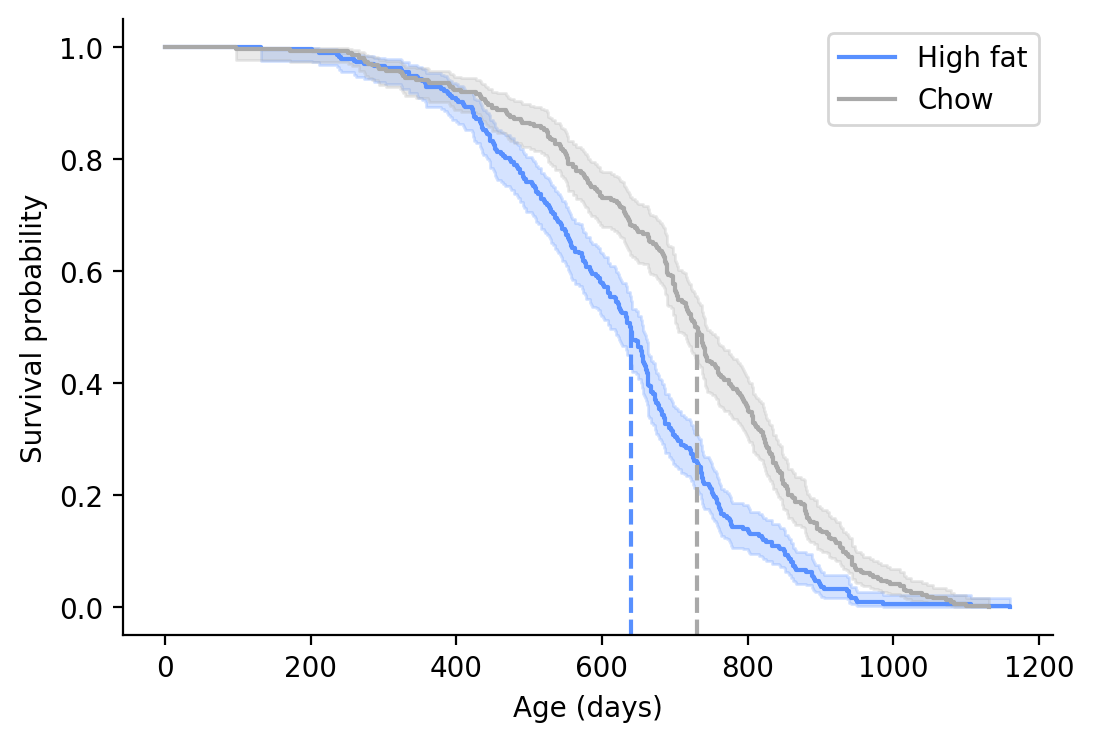

In [66]:
# plot a kaplan-meier curve for contrasting the survival by diet
fig, axes = plt.subplots(1, 1, figsize = (6, 4))

kmf_hf = KaplanMeierFitter()
kmf_hf.fit(
    durations = survive.query('DietCode == "HF"')['AgeAtDeath'],
    event_observed = survive.query('DietCode == "HF"')['lifestatus'],
    label = "High fat"
    )
kmf_hf.plot(
    show_censors = True, ci_show = True, ax = axes, color = my_categorical_palette[3], alpha = 1,
    )

kmf_cd = KaplanMeierFitter()
kmf_cd.fit(
    durations = survive.query('DietCode == "CD"')['AgeAtDeath'],
    event_observed = survive.query('DietCode == "CD"')['lifestatus'],
    label = "Chow"
    )
kmf_cd.plot(show_censors = True, ci_show = True, ax = axes, color = 'darkgrey', alpha = 1)
sns.despine()
axes.set_xlabel("Age (days)")
axes.set_ylabel("Survival probability")
# print median survival time of each
print("Median survival time on HF diet: ", kmf_hf.median_survival_time_)
print("Median survival time on CD diet: ", kmf_cd.median_survival_time_)
# draw vertical line at median survival time
axes.axvline(kmf_hf.median_survival_time_, color = my_categorical_palette[3], linestyle = '--', ymax=0.5)
axes.axvline(kmf_cd.median_survival_time_, color = 'darkgrey', linestyle = '--', ymax=0.5)
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/survival_curves_by_diet.svg")

In [19]:
num_mice_per_strain = survive.query("DietCode == 'CD'").groupby('StrainNameCurrent').size()
# keep only strains with > 5 individuals
strains = num_mice_per_strain[num_mice_per_strain >= 3].index
survive.query("StrainNameCurrent in @strains").groupby('DietCode')['EarTagNumberOriginal'].nunique()

DietCode
CD    498
HF    522
Name: EarTagNumberOriginal, dtype: int64

# Count plot

/tmp/ipykernel_1793418/213312687.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)


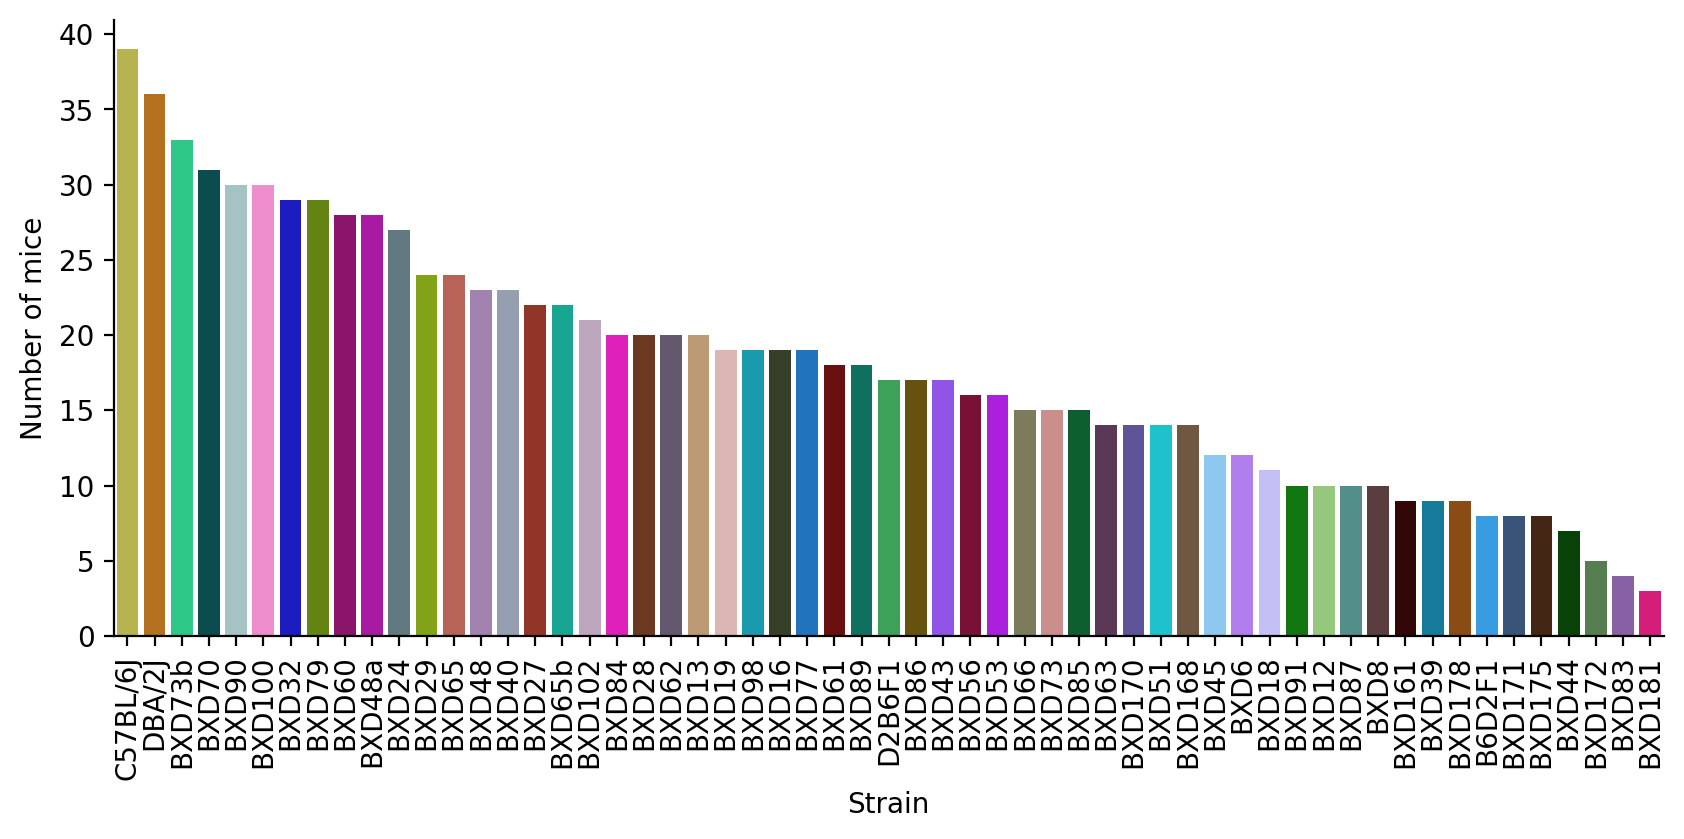

In [20]:
# plot number of mice per strain
fig, axes = plt.subplots(1, 1, figsize = (10, 4))
num_mice_per_strain = survive.groupby('StrainNameCurrent').size()
num_mice_per_strain = num_mice_per_strain.loc[strains]
# order by number of mice
num_mice_per_strain = num_mice_per_strain.sort_values(ascending = False).reset_index()
num_mice_per_strain.columns = ['Strain', 'Number of mice']

sns.barplot(data = num_mice_per_strain, x = 'Strain', y = 'Number of mice', hue = 'Strain', palette = strain_palette, ax = axes)
_ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)
sns.despine()


/tmp/ipykernel_2479661/4149556523.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)


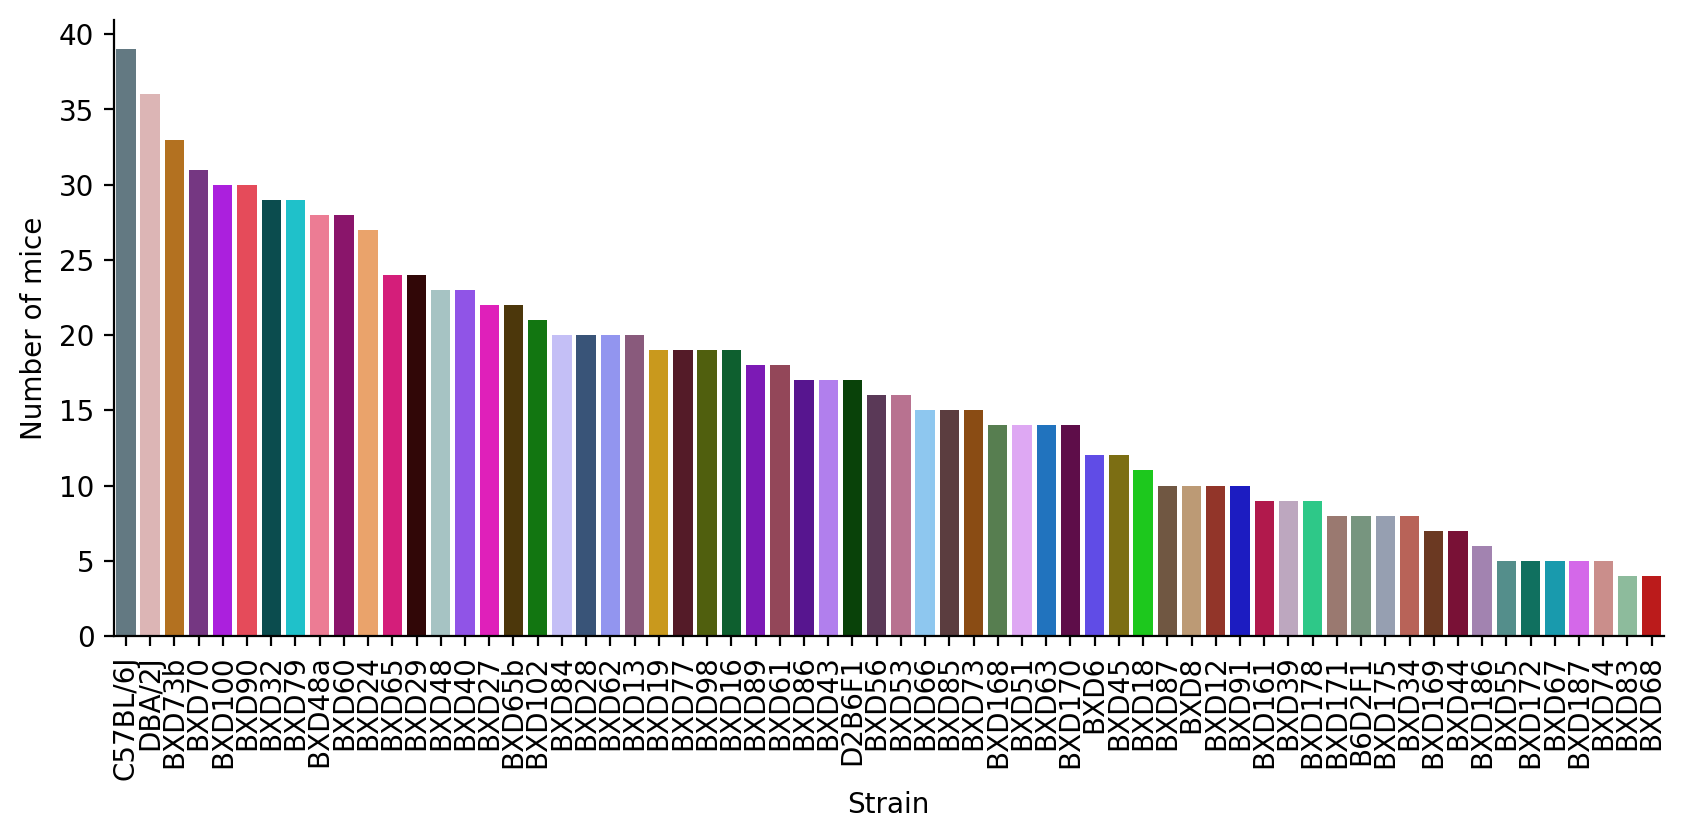

In [26]:
# plot number of mice per strain
fig, axes = plt.subplots(1, 1, figsize = (10, 4))
num_mice_per_strain = survive.groupby('StrainNameCurrent').size()
num_mice_per_strain = num_mice_per_strain.loc[strains]
# order by number of mice
num_mice_per_strain = num_mice_per_strain.sort_values(ascending = False).reset_index()
num_mice_per_strain.columns = ['Strain', 'Number of mice']

sns.barplot(data = num_mice_per_strain, x = 'Strain', y = 'Number of mice', hue = 'Strain', palette = strain_palette, ax = axes)
_ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)
sns.despine()
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/count_of_mice.svg")


# DREAM activity by strain

In [12]:
williams.dream_expression.groupby('Diet3')['AnimalEarTag'].nunique()

Diet3
CD    150
HF    120
Name: AnimalEarTag, dtype: int64

In [11]:
# get mean values for each strain-diet group
strain_means = williams.dream_expression.groupby(['Strain3','Diet3'])['DREAM_normalized_enrichment_score_resid'].mean().reset_index()
# pivot to get CD and HF columns
strain_means_wide = strain_means.pivot(index='Strain3', columns='Diet3', values='DREAM_normalized_enrichment_score_resid')
# calculate correlation between CD and HF values
pearsonr(strain_means_wide['CD'], strain_means_wide['HF'])

PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))

/tmp/ipykernel_2479661/3905361784.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)


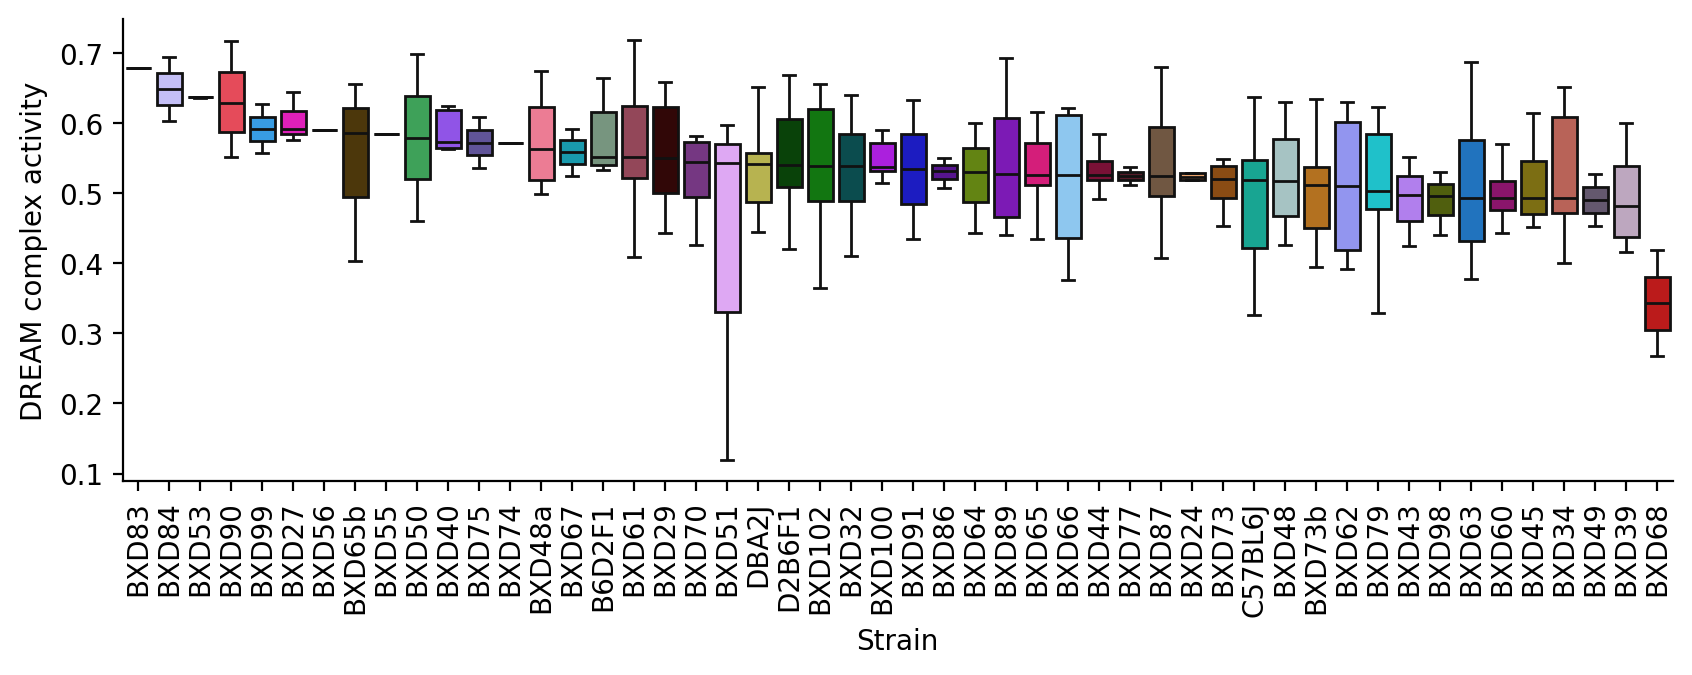

In [34]:
fig, axes = plt.subplots(1, 1, figsize = (10, 3))
# order boxes by median expression in strain
order = williams.dream_expression.groupby('Strain3')['DREAM_normalized_enrichment_score_resid'].quantile(0.5).sort_values(ascending=False).index
# include only strains with at least 3 samples
#strain_counts = williams.dream_expression['Strain3'].value_counts()
#to_include = strain_counts[strain_counts >= 3].index
#order = [x for x in order if x in to_include]

sns.boxplot(
    williams.dream_expression, x = 'Strain3', y = 'DREAM_normalized_enrichment_score_resid', hue = 'Strain3',
    ax = axes, order = order,
    palette = strain_palette, showfliers = False,
    )
_ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)
sns.despine()
plt.ylabel("DREAM complex activity")
plt.xlabel("Strain")
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/dream_activity_by_strain_cd.svg")

# Survival analysis

In [16]:
', '.join(covariates_to_use)

'BodyWeight, LiverWeight, LiverWeight_PctBW, HeartWeight, HeartWeight_PctBW, SpleenWeight, KidneysWeight, PerirenalWATWeight, PerigonadalWATWeight, SubcutaneousWATWeight, GastrocWeight, QuadricepsWeight, SoleusWeight, HDL, LDL, TotalChol, ALT, ASAT, ALToverASAT, Creatinine, CreatineKinase, Glucose, LDH, Triglycerides, Bilirubin, FFA, BileAcids, Lactate, Protein, ALPL, Iron, Amylase'

In [8]:
# choose which covariates to include
covariates_to_use = ['BodyWeight', 'LiverWeight', 'LiverWeight_PctBW',
       'HeartWeight', 'HeartWeight_PctBW', 'SpleenWeight', 'KidneysWeight',
       'PerirenalWATWeight', 'PerigonadalWATWeight', 'SubcutaneousWATWeight',
       'GastrocWeight', 'QuadricepsWeight', 'SoleusWeight',
       'HDL', 'LDL', 'TotalChol', 'ALT', 'ASAT',
       'ALToverASAT', 'Creatinine', 'CreatineKinase', 'Glucose', 'LDH',
       'Triglycerides', 'Bilirubin', 'FFA', 'BileAcids', 'Lactate', 'Protein',
       'ALPL', 'Iron', 'Amylase', 'total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']
#covariates_to_use = ['DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']

# get mean of the covariates within each strain-diet group
mean_df = williams.dream_expression.groupby(
    ['Strain3', 'Diet3']
    )[covariates_to_use].mean()
mean_df.reset_index(inplace = True)
survive = survive.merge(mean_df, left_on = ['StrainNameCurrent', 'DietCode'], right_on = ['Strain3', 'Diet3'], how = 'left')
survive.dropna(subset = covariates_to_use, inplace = True)


'dream_std_by_strain = williams.dream_expression.groupby([\'Strain3\', \'Diet3\'])[\'DREAM_normalized_enrichment_score_resid\'].std().reset_index()\ndream_std_by_strain.columns = [\'Strain3\', \'Diet3\', \'std\']\n# add counts to this\ncounts = williams.dream_expression.groupby([\'Strain3\', \'Diet3\']).size().reset_index()\ncounts.columns = [\'Strain3\', \'Diet3\', \'count\']\n# comnbine\ndream_std_by_strain = dream_std_by_strain.merge(counts, on = [\'Strain3\', \'Diet3\'])\n# select strain-diet pairs with stdev > 0.15\nhigh_std = dream_std_by_strain.query(\'std > .2\') \nlow_count = dream_std_by_strain.query(\'count < 0\') \n# drop strains from survive that have high dream std or low sample count\nsurvive = survive.query(\'StrainNameCurrent not in @high_std["Strain3"] and StrainNameCurrent not in @low_count["Strain3"]\')\n\n# add in mouse specific covariates\n#covariates_to_use += [\'Weight01\' , \'Weight00Baseline\',\'WeightChangeBaseTo01\']\nsurvive.dropna(subset = covariates_to_us

### Use PCs as covariates

In [9]:
def add_pcs(df, n_pcs):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    df_scaled = scaler.fit_transform(df)

    pca = PCA(n_components=n_pcs)
    pcs = pca.fit_transform(df_scaled)
    pcs_df = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(n_pcs)])
    pcs_df.index = df.index
    
    # plot explained variance
    fig, axes = plt.subplots(1, 1, figsize = (4, 4))
    axes.plot(pca.explained_variance_ratio_)
    axes.set_xlabel("Principal component  - 1")
    axes.set_ylabel("Explained variance")
    return pd.concat([df, pcs_df], axis=1)

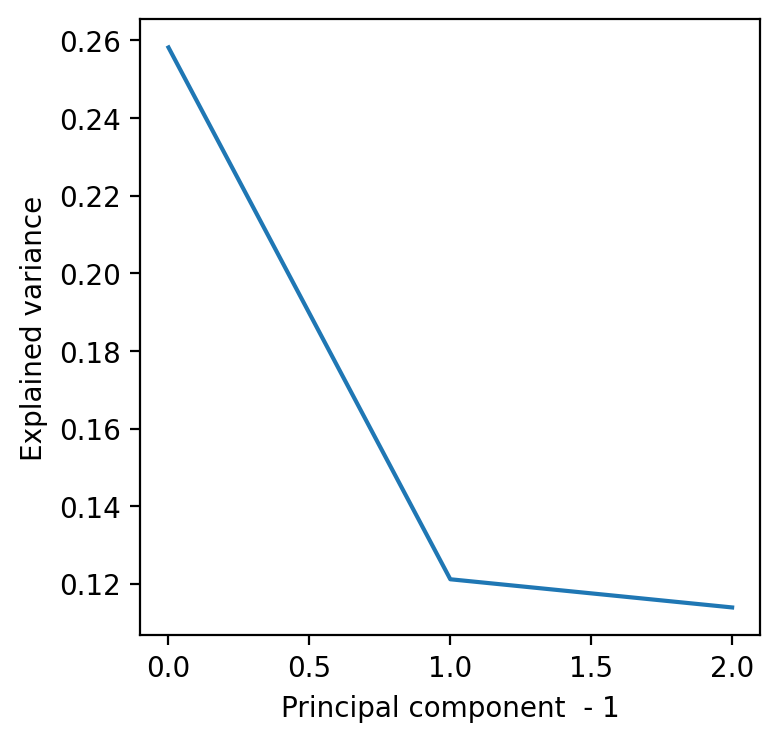

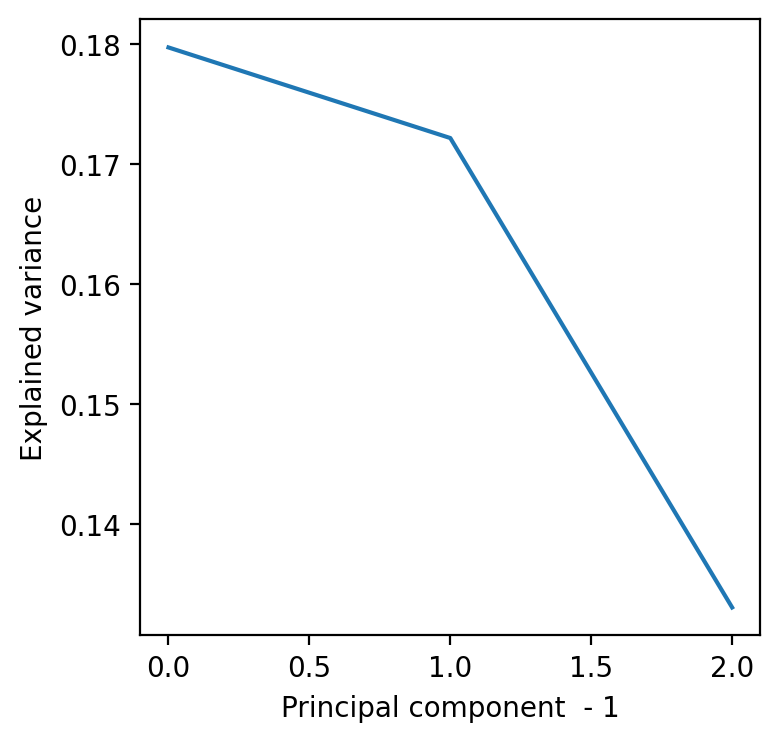

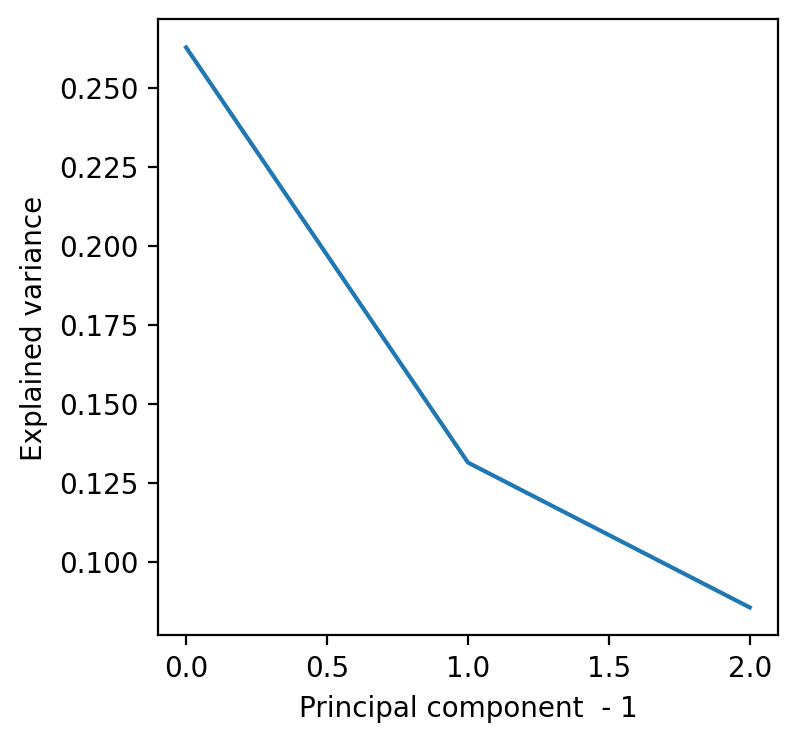

In [10]:
[covariates_to_use.remove(x) for x in ['total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']]

# add pcs to the data
survive_hf = add_pcs(survive.query("Diet3 == 'HF'")[covariates_to_use], 3)
survive_cd = add_pcs(survive.query("Diet3 == 'CD'")[covariates_to_use], 3)
survive_both = add_pcs(survive[covariates_to_use], 3)
# add other variables
survive_hf[['AgeAtDeath', 'lifestatus', 'total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01', 'BodyWeight']] = survive[
    ['AgeAtDeath', 'lifestatus', 'total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01', 'BodyWeight']
    ].copy()
survive_cd[['AgeAtDeath', 'lifestatus',  'total_seq_depth', 'n_genes_expressed','DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01', 'BodyWeight']] = survive[
    ['AgeAtDeath', 'lifestatus',  'total_seq_depth', 'n_genes_expressed','DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01', 'BodyWeight']
    ].copy()
survive_both[['AgeAtDeath', 'lifestatus',  'total_seq_depth', 'n_genes_expressed','DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01','Diet3', 'BodyWeight']] = survive[
    ['AgeAtDeath', 'lifestatus', 'total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'Weight01' , 'Weight00Baseline','WeightChangeBaseTo01','Diet3', 'BodyWeight']
    ].copy()

/tmp/ipykernel_4043577/3458438183.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)


Text(0, 0.5, 'Correlation with PC1 (Pearson r)')

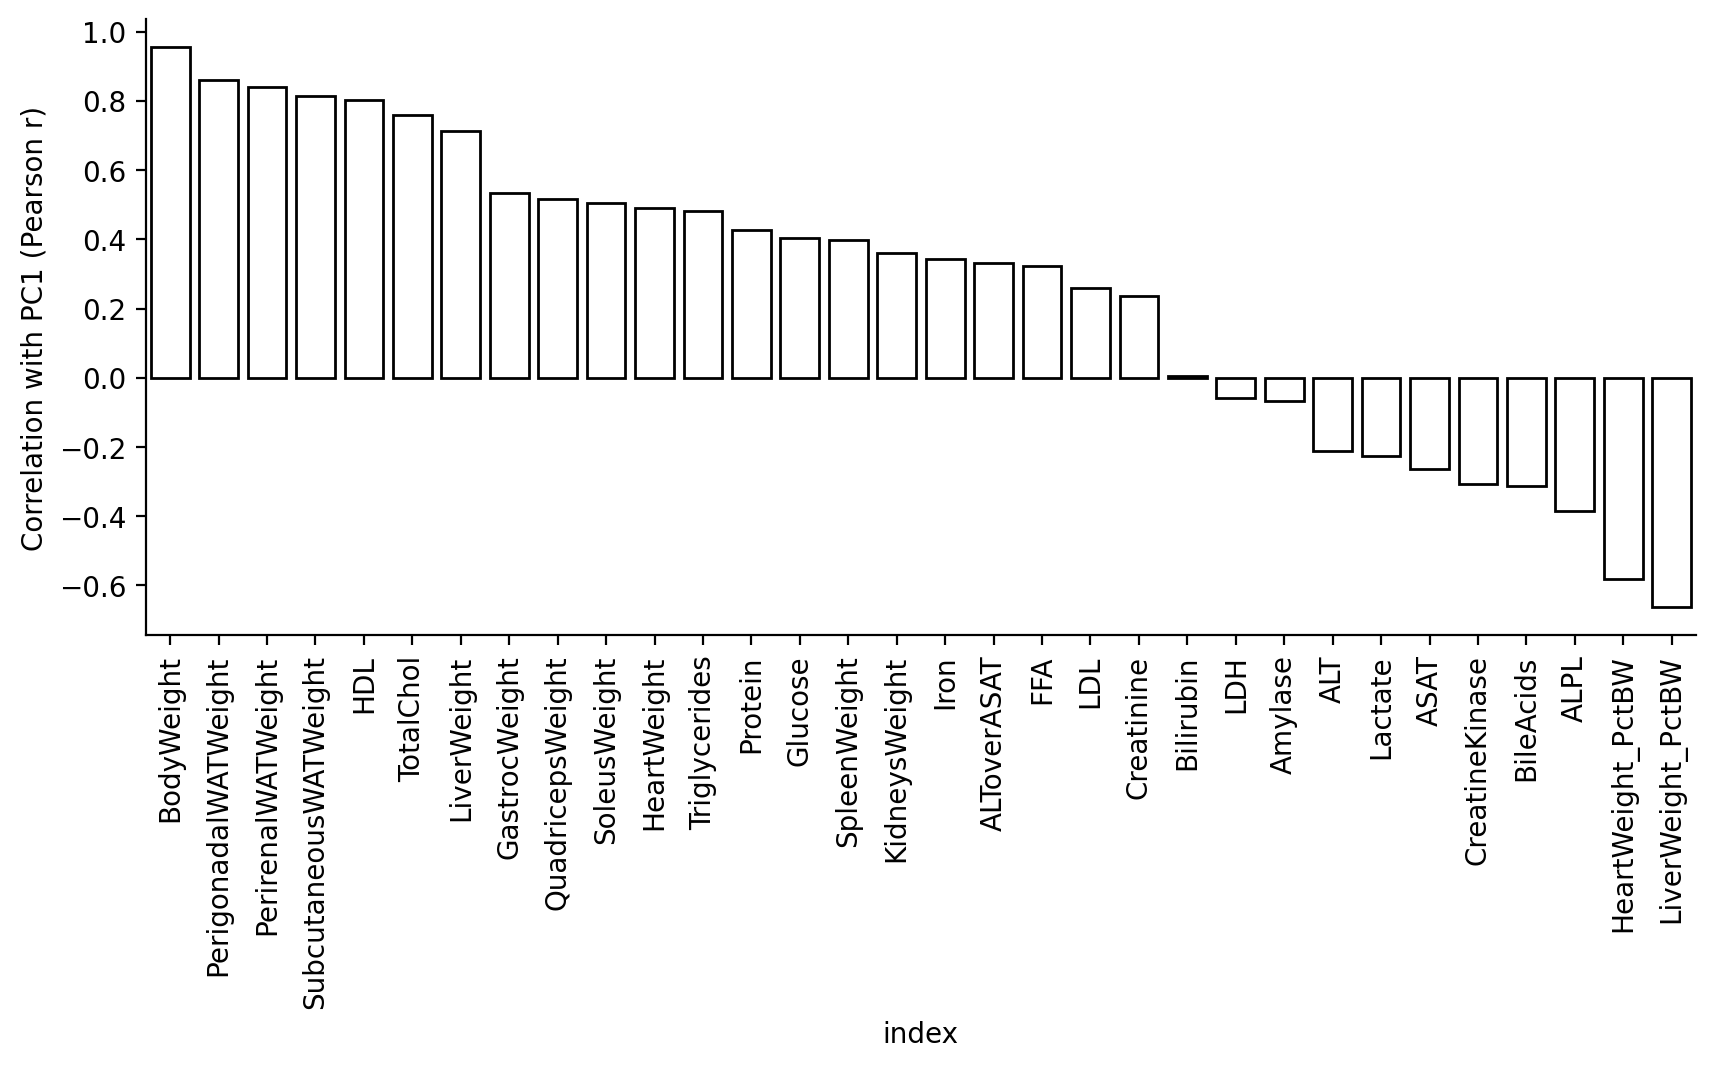

In [11]:
# get correlation of PC1 with each variable
corrs = survive_both[['PC1'] + covariates_to_use].corr()['PC1'].sort_values(ascending = False)
# remove pc1 from list
corrs = corrs.drop('PC1')
# plot as barplot
fig, axes = plt.subplots(1, 1, figsize = (10, 4))
sns.barplot(data = corrs.reset_index(), x = 'index', y = 'PC1', ax = axes, color = 'white', edgecolor = 'black')
_ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90)
sns.despine()
axes.set_ylabel("Correlation with PC1 (Pearson r)")
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/pc1_correlation.svg")

Text(0.5, 1.0, 'All mice')

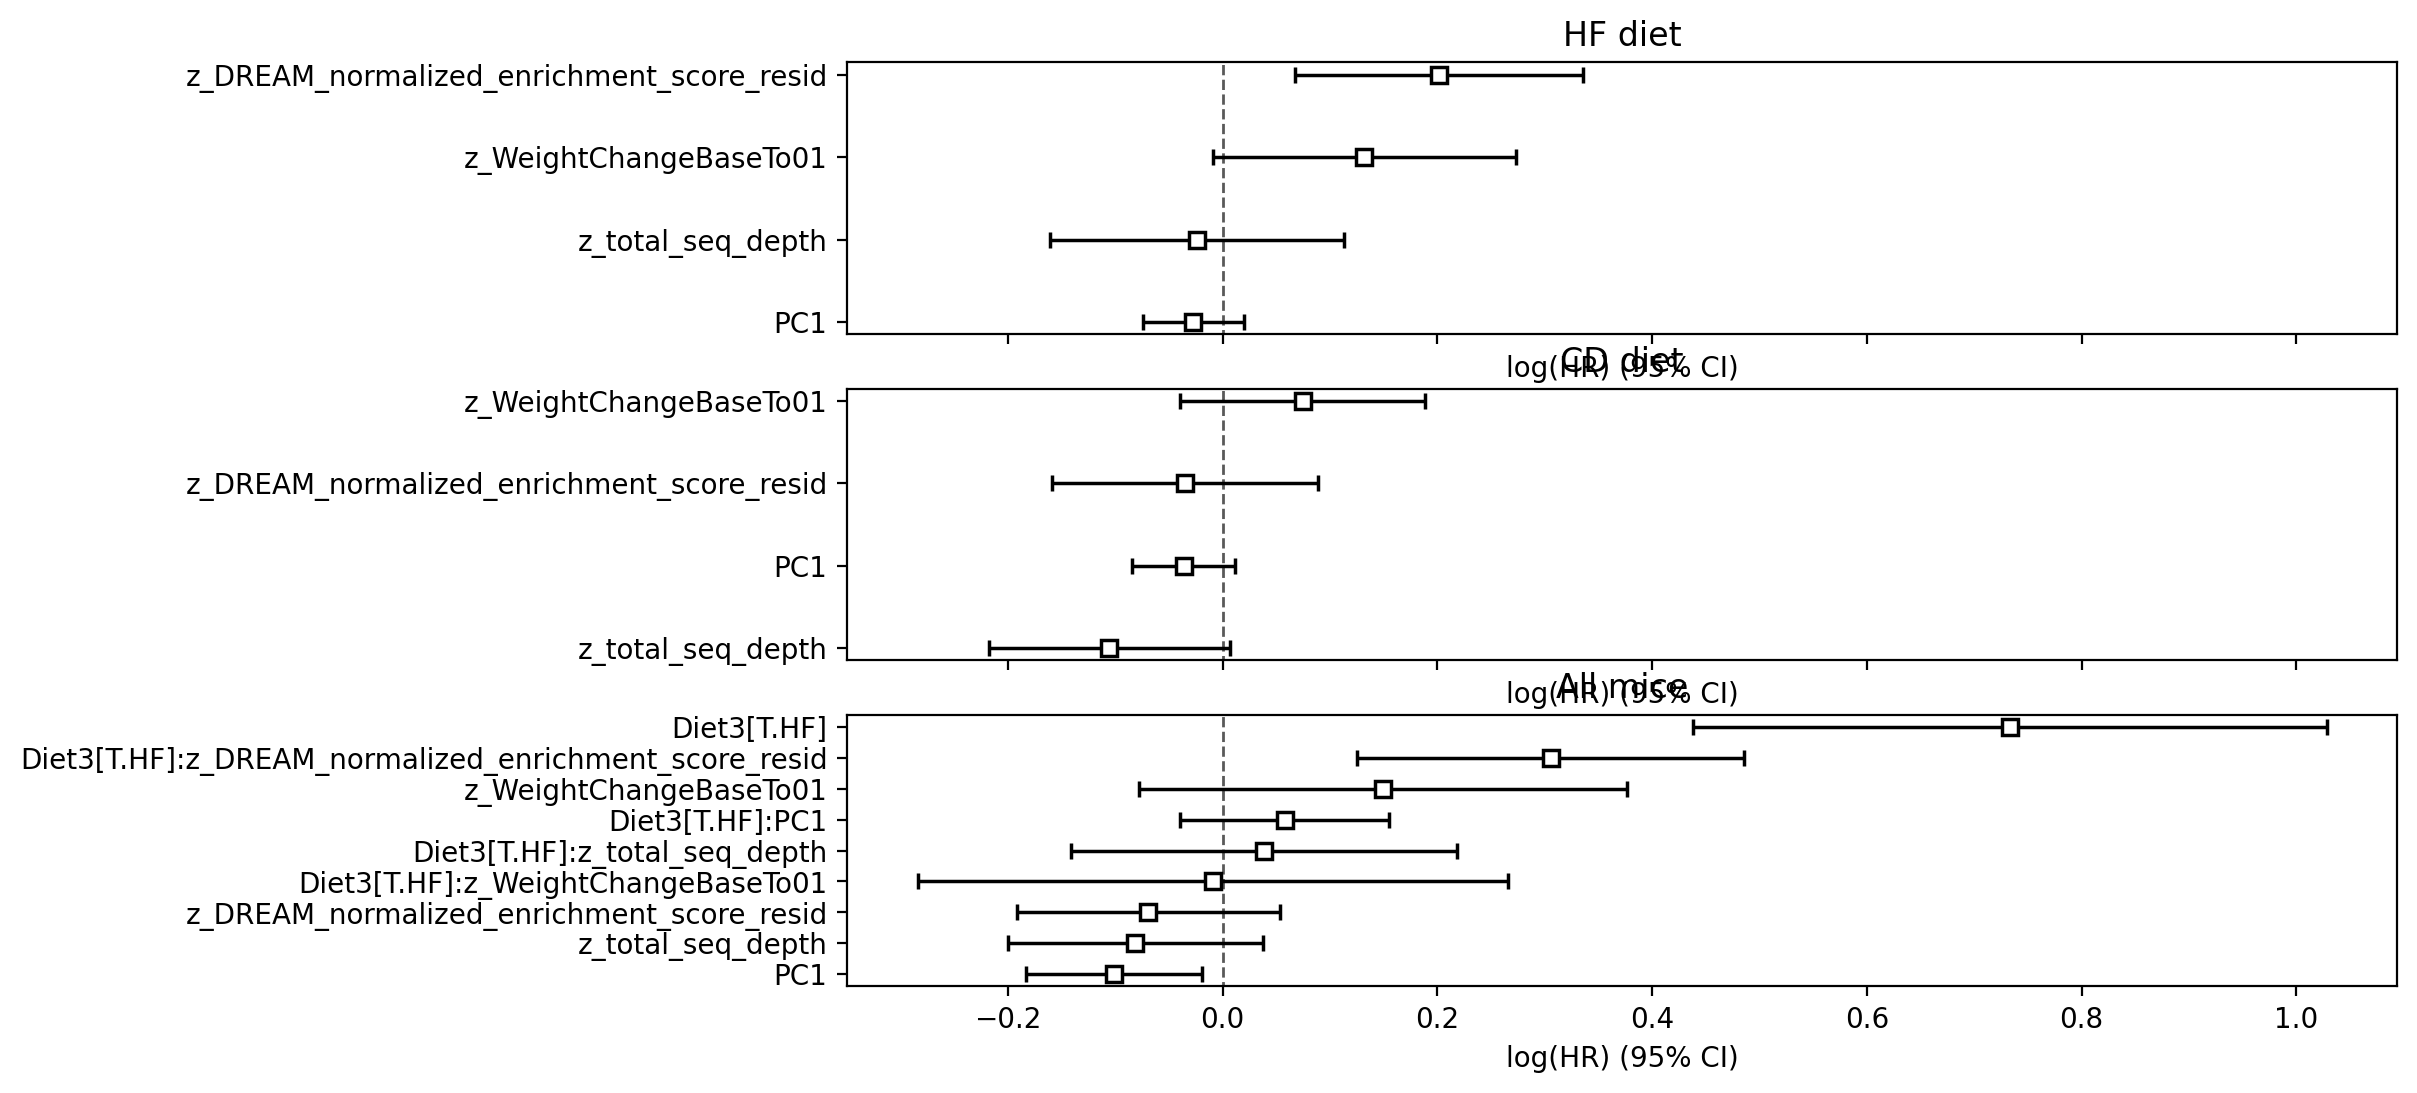

In [12]:
fig, axes = plt.subplots(3, 1, figsize = (10, 6), sharey = False, sharex = True)
# HF only
# Diet3 * Weight_change * DREAM_activity
formula_str = " \
    z_DREAM_normalized_enrichment_score_resid \
    + PC1 \
    + z_total_seq_depth \
    + z_WeightChangeBaseTo01 \
    "

        
# both only
both_formula_str = " \
    Diet3 * z_DREAM_normalized_enrichment_score_resid \
    + Diet3 * PC1 \
    + Diet3 * z_total_seq_depth \
    + Diet3 * z_WeightChangeBaseTo01 \
    "

# zscore the variables in the formula
survive_hf['z_DREAM_normalized_enrichment_score_resid'] = (survive_hf['DREAM_normalized_enrichment_score_resid'] - survive_hf['DREAM_normalized_enrichment_score_resid'].mean()) / survive_hf['DREAM_normalized_enrichment_score_resid'].std()
survive_hf['z_Weight01'] = (survive_hf['Weight01'] - survive_hf['Weight01'].mean()) / survive_hf['Weight01'].std()
survive_hf['z_WeightChangeBaseTo01'] = (survive_hf['WeightChangeBaseTo01'] - survive_hf['WeightChangeBaseTo01'].mean()) / survive_hf['WeightChangeBaseTo01'].std()
survive_hf['z_total_seq_depth'] = (survive_hf['total_seq_depth'] - survive_hf['total_seq_depth'].mean()) / survive_hf['total_seq_depth'].std()
survive_hf['z_BodyWeight'] = (survive_hf['BodyWeight'] - survive_hf['BodyWeight'].mean()) / survive_hf['BodyWeight'].std()
survive_hf['z_Weight00Baseline'] = (survive_hf['Weight00Baseline'] - survive_hf['Weight00Baseline'].mean()) / survive_hf['Weight00Baseline'].std()
survive_hf['z_Weight01'] = (survive_hf['Weight01'] - survive_hf['Weight01'].mean()) / survive_hf['Weight01'].std()
cph = CoxPHFitter()
cph.fit(
    survive_hf.dropna(),
    duration_col = 'AgeAtDeath', event_col = 'lifestatus', formula = formula_str, show_progress=False,
    )
cph.plot(ax = axes[0])
axes[0].set_title("HF diet")


# CD only
# zscore the variables in the formula
survive_cd['z_DREAM_normalized_enrichment_score_resid'] = (survive_cd['DREAM_normalized_enrichment_score_resid'] - survive_cd['DREAM_normalized_enrichment_score_resid'].mean()) / survive_cd['DREAM_normalized_enrichment_score_resid'].std()
survive_cd['z_Weight01'] = (survive_cd['Weight01'] - survive_cd['Weight01'].mean()) / survive_cd['Weight01'].std()
survive_cd['z_WeightChangeBaseTo01'] = (survive_cd['WeightChangeBaseTo01'] - survive_cd['WeightChangeBaseTo01'].mean()) / survive_cd['WeightChangeBaseTo01'].std()
survive_cd['z_total_seq_depth'] = (survive_cd['total_seq_depth'] - survive_cd['total_seq_depth'].mean()) / survive_cd['total_seq_depth'].std()
survive_cd['z_BodyWeight'] = (survive_cd['BodyWeight'] - survive_cd['BodyWeight'].mean()) / survive_cd['BodyWeight'].std()
survive_cd['z_Weight00Baseline'] = (survive_cd['Weight00Baseline'] - survive_cd['Weight00Baseline'].mean()) / survive_cd['Weight00Baseline'].std()
survive_cd['z_Weight01'] = (survive_cd['Weight01'] - survive_cd['Weight01'].mean()) / survive_cd['Weight01'].std()
cph = CoxPHFitter()
cph.fit(
    survive_cd.dropna(),
    duration_col = 'AgeAtDeath', event_col = 'lifestatus', formula = formula_str, show_progress=False,
    )
cph.plot(ax = axes[1])
axes[1].set_title("CD diet")



# zscore the variables in the formula
survive_both['z_DREAM_normalized_enrichment_score_resid'] = (survive_both['DREAM_normalized_enrichment_score_resid'] - survive_both['DREAM_normalized_enrichment_score_resid'].mean()) / survive_both['DREAM_normalized_enrichment_score_resid'].std()
survive_both['z_Weight01'] = (survive_both['Weight01'] - survive_both['Weight01'].mean()) / survive_both['Weight01'].std()
survive_both['z_WeightChangeBaseTo01'] = (survive_both['WeightChangeBaseTo01'] - survive_both['WeightChangeBaseTo01'].mean()) / survive_both['WeightChangeBaseTo01'].std()
survive_both['z_total_seq_depth'] = (survive_both['total_seq_depth'] - survive_both['total_seq_depth'].mean()) / survive_both['total_seq_depth'].std()
survive_both['z_n_genes_expressed'] = (survive_both['n_genes_expressed'] - survive_both['n_genes_expressed'].mean()) / survive_both['n_genes_expressed'].std()
survive_both['z_BodyWeight'] = (survive_both['BodyWeight'] - survive_both['BodyWeight'].mean()) / survive_both['BodyWeight'].std()
survive_both['z_Weight00Baseline'] = (survive_both['Weight00Baseline'] - survive_both['Weight00Baseline'].mean()) / survive_both['Weight00Baseline'].std()
survive_hf['z_Weight01'] = (survive_hf['Weight01'] - survive_hf['Weight01'].mean()) / survive_hf['Weight01'].std()
cph = CoxPHFitter()
cph.fit(
    survive_both.dropna(),
    duration_col = 'AgeAtDeath', event_col = 'lifestatus', formula = both_formula_str, show_progress=False,
    )
cph.plot(ax = axes[2])
axes[2].set_title("All mice")


In [35]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Diet3[T.HF],0.733023,2.081362,0.150614,0.437825,1.028220,1.549333,2.796086,0.0,4.866897,0.000001,19.750607
z_DREAM_normalized_enrichment_score_resid,-0.069046,0.933283,0.062629,-0.191797,0.053705,0.825474,1.055173,0.0,-1.102463,0.270260,1.887578
PC1,-0.100991,0.903941,0.041921,-0.183156,-0.018826,0.832639,0.981350,0.0,-2.409052,0.015994,5.966326
z_total_seq_depth,-0.081252,0.921961,0.060590,-0.200007,0.037503,0.818725,1.038215,0.0,-1.341007,0.179918,2.474587
z_WeightChangeBaseTo01,0.149368,1.161101,0.115918,-0.077826,0.376563,0.925125,1.457267,0.0,1.288573,0.197546,2.339736
Diet3[T.HF]:z_DREAM_normalized_enrichment_score_resid,0.305403,1.357171,0.091878,0.125326,0.485480,1.133517,1.624954,0.0,3.324011,0.000887,10.138247
Diet3[T.HF]:PC1,0.057718,1.059416,0.049600,-0.039497,0.154932,0.961273,1.167579,0.0,1.163655,0.244564,2.031718
Diet3[T.HF]:z_total_seq_depth,0.038736,1.039496,0.091747,-0.141084,0.218557,0.868416,1.244280,0.0,0.422209,0.672873,0.571595
Diet3[T.HF]:z_WeightChangeBaseTo01,-0.009256,0.990787,0.140304,-0.284248,0.265736,0.752580,1.304390,0.0,-0.065971,0.947401,0.077953


In [34]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 608 total observations, 0 right-censored observations>
             duration col = 'AgeAtDeath'
                event col = 'lifestatus'
      baseline estimation = breslow
   number of observations = 608
number of events observed = 608
   partial log-likelihood = -3258.12
         time fit was run = 2024-08-29 20:11:23 UTC

---
                                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                              
Diet3[T.HF]                                            0.73      2.08      0.15            0.44            1.03                1.55                2.80
z_DREAM_normalized_enrichment_score_resid             -0.07      0.93      0.06           -0.19            0.05                0.83                1.06
PC1                                                   -0.10      0.90      0.04           -0.18           -0.02                0.83                0.98
z_total_seq_depth                                     -0.08      0.92      0.06           -0.20            0.04                0.82                1.04
z_WeightChangeBaseTo01                                 0.15      1.16      0.12           -0.08            0.38                0.93                1.46
Diet3[T.HF]:z_DREAM_normalized_enrichment_score_resid  0.31      1.36      0.09            0.13            0.49                1.13                1.62
Diet3[T.HF]:PC1                                        0.06      1.06      0.05           -0.04            0.15                0.96                1.17
Diet3[T.HF]:z_total_seq_depth                          0.04      1.04      0.09           -0.14            0.22                0.87                1.24
Diet3[T.HF]:z_WeightChangeBaseTo01                    -0.01      0.99      0.14           -0.28            0.27                0.75                1.30

                                                       cmp to     z      p  -log2(p)
covariate                                                                           
Diet3[T.HF]                                              0.00  4.87 <0.005     19.75
z_DREAM_normalized_enrichment_score_resid                0.00 -1.10   0.27      1.89
PC1                                                      0.00 -2.41   0.02      5.97
z_total_seq_depth                                        0.00 -1.34   0.18      2.47
z_WeightChangeBaseTo01                                   0.00  1.29   0.20      2.34
Diet3[T.HF]:z_DREAM_normalized_enrichment_score_resid    0.00  3.32 <0.005     10.14
Diet3[T.HF]:PC1                                          0.00  1.16   0.24      2.03
Diet3[T.HF]:z_total_seq_depth                            0.00  0.42   0.67      0.57
Diet3[T.HF]:z_WeightChangeBaseTo01                       0.00 -0.07   0.95      0.08
---
Concordance = 0.60
Partial AIC = 6534.24
log-likelihood ratio test = 70.78 on 9 df
-log2(p) of ll-ratio test = 36.45

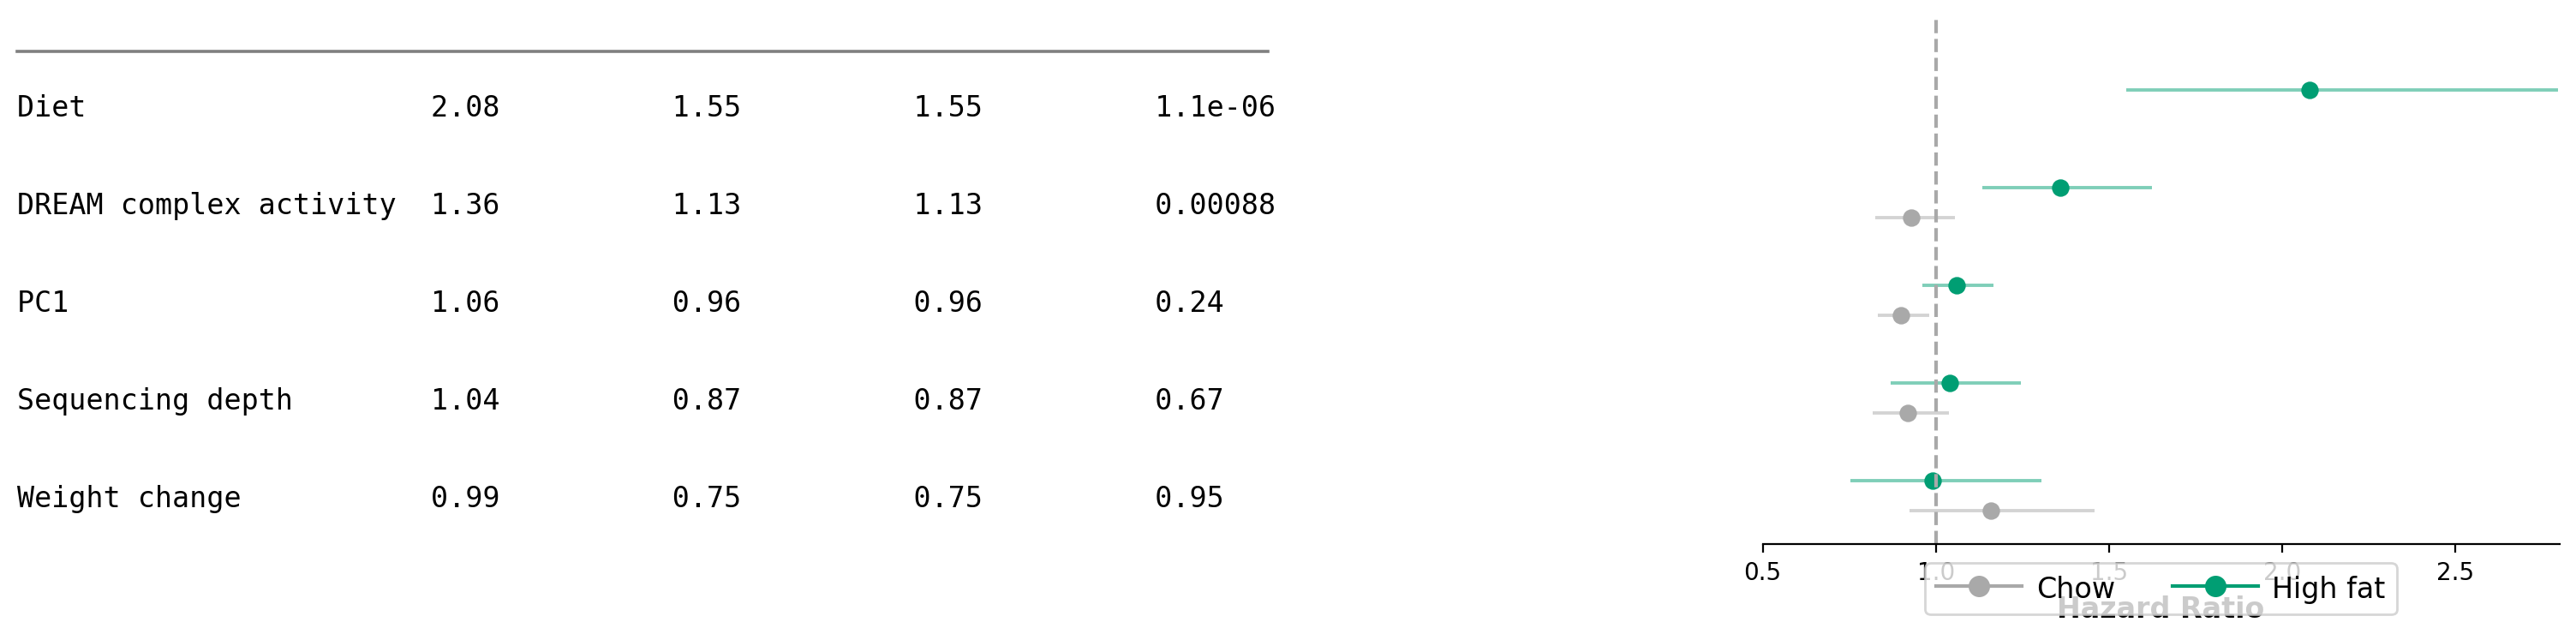

In [13]:
import forestplot as fp
forest_df = cph.summary.reset_index()
# add a group column  
forest_df['group'] = ['Diet & Weight', 'DREAM activity', 'Diet & Weight', 'Sequencing', 'Diet & Weight', 'DREAM activity', 'Diet & Weight', 'Sequencing', 'Diet & Weight']
group_order = [ 'Diet & Weight', 'DREAM activity', 'Sequencing']
# add model col
forest_df['model'] = ['High fat', 'Chow', 'Chow', 'Chow', 'Chow', 'High fat','High fat', 'High fat','High fat']
# reanme covariates
forest_df['covariate'] = ['Diet', 'DREAM complex activity', 'PC1', 'Sequencing depth', 'Weight change', 'DREAM complex activity','PC1','Sequencing depth','Weight change']

# round values
forest_df['exp(coef)'] = forest_df['exp(coef)'].round(2)
forest_df['rounded exp(coef) lower 95%'] = forest_df['exp(coef) lower 95%'].round(2)
forest_df['rounded exp(coef) upper 95%'] = forest_df['exp(coef) lower 95%'].round(2)
forest_df['rounded p'] = forest_df['p'].apply(lambda x: f"{x:.2}")

axxx = fp.mforestplot(
    dataframe = forest_df,
    figsize = (6, 4),
    xlim = (0.5, 2.8),
    estimate="exp(coef)",  # col containing estimated effect size 
    ll="exp(coef) lower 95%", hl="exp(coef) upper 95%",  # columns containing conf. int. lower and higher limits
    varlabel="covariate",  # column containing variable label
    ylabel="Confidence interval",  # y-label title
    xlabel="Hazard Ratio",  # x-label title
    #groupvar="group",  # column containing group labels
    #group_order = group_order,
    model_col="model",
    modellabels=["Chow", "High fat"],  # labels for models
    msymbols=["o", "o"],  # Markers for models
    mcolor=["darkgrey", my_categorical_palette[0]],
    sort=True,
    #color_alt_rows=True,  # Gray alternate rows
    annote=["exp(coef)", "rounded exp(coef) lower 95%", "rounded exp(coef) upper 95%", "rounded p"],  # columns to report on left of plot
    annoteheaders=["Hazard Ratio", "95% CI Lower", "95% CI Upper", "p-value"],  # headers for columns to report on left of plot
    table=True,  # Format as a table
    capsize = 2.5
    )
# add vertical line at 0
axxx.axvline(1, color='darkgrey', linestyle='--')
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/fig_mouse_survival/cox_forest_plot.svg")

### Kaplan-Meier survival curves by dream

In [11]:
survive['Diet3'].value_counts()

Diet3
CD    313
HF    299
Name: count, dtype: int64

In [9]:
hf_surive_df['StrainNameCurrent'].nunique()

14

/tmp/ipykernel_84225/1101484178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hf_surive_df['DREAM_bin'] = pd.qcut(hf_surive_df['DREAM_normalized_enrichment_score_resid'], 5, labels = ['Lowest 20%', 'Low-Mid', 'Mid', 'Mid-High', 'Highest 20%'])


Median survival time in lowest bin:  678.0
Median survival time in highest bin:  578.0
   test_statistic         p   -log2(p)
0       16.567135  0.000047  14.378277


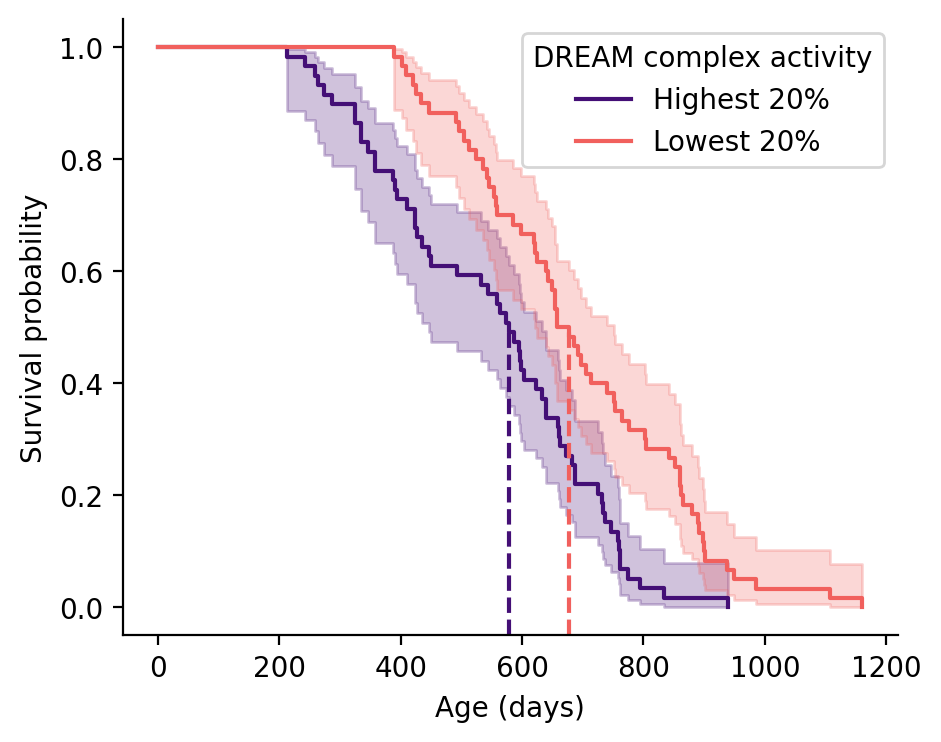

In [18]:
hf_surive_df = survive.query("Diet3 == 'HF'")
# bin DREAM in 5 bins
hf_surive_df['DREAM_bin'] = pd.qcut(hf_surive_df['DREAM_normalized_enrichment_score_resid'], 5, labels = ['Lowest 20%', 'Low-Mid', 'Mid', 'Mid-High', 'Highest 20%'])
# keep only most extreme bins
hf_surive_df = hf_surive_df.query('DREAM_bin in ["Lowest 20%", "Highest 20%"]')
# plot survival curves for each bin
fig, axes = plt.subplots(1, 1, figsize = (5, 4))
# get categorical colormap of magma
cmap = plt.get_cmap('magma')
# get colors
colors = cmap(np.linspace(0, 1, 10))
# keep only middle 5 colors
colors = colors[[2, 6]]
# create a dictionary of colors
color_dict = dict(zip(hf_surive_df['DREAM_bin'].unique(), colors))

median_survival = {}
for i, bin_val in enumerate(hf_surive_df['DREAM_bin'].unique()):
    mask = hf_surive_df['DREAM_bin'] == bin_val
    # Create a KaplanMeierFitter object
    this_strain_kmf = KaplanMeierFitter()
    this_strain_kmf.fit(
        durations = hf_surive_df['AgeAtDeath'][mask],
        event_observed = hf_surive_df['lifestatus'][mask], 
        label = bin_val
        )
    # plot survival curve without confidence intervals
    this_strain_kmf.plot(show_censors = False, ci_show = True,  ax = axes, alpha = 1, color = color_dict[bin_val])
    median_survival[bin_val] = this_strain_kmf.median_survival_time_
    
sns.despine()
# set axes labels
axes.set_xlabel("Age (days)")
axes.set_ylabel("Survival probability")
# name legend
axes.legend(title = "DREAM complex activity")
# draw a vertical dashed line at 50% survival for each bin
for bin_val in hf_surive_df['DREAM_bin'].unique():
    axes.axvline(median_survival[bin_val], linestyle = '--', color = color_dict[bin_val], ymax=0.5)
    
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/fig_mouse_survival/survival_curves_by_dream_hf.svg")
# print median survival time of each
print("Median survival time in lowest bin: ", median_survival['Lowest 20%'])
print("Median survival time in highest bin: ", median_survival['Highest 20%'])

from lifelines.statistics import logrank_test

results = logrank_test(
    hf_surive_df.query('DREAM_bin == "Lowest 20%"')['AgeAtDeath'],
    hf_surive_df.query('DREAM_bin == "Highest 20%"')['AgeAtDeath'],
    hf_surive_df.query('DREAM_bin == "Lowest 20%"')['lifestatus'],
    hf_surive_df.query('DREAM_bin == "Highest 20%"')['lifestatus'],
    alpha = 0.95
    )
print(results.summary)

In [22]:
cd_surive_df['StrainNameCurrent'].nunique()

15

/tmp/ipykernel_84225/254599935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_surive_df['DREAM_bin'] = pd.qcut(cd_surive_df['DREAM_normalized_enrichment_score_resid'], 5, labels = ['Lowest 20%', 'Low-Mid', 'Mid', 'Mid-High', 'Highest 20%'])


Median survival time in lowest bin:  687.0
Median survival time in highest bin:  735.0
   test_statistic         p  -log2(p)
0         3.71171  0.054032  4.210042


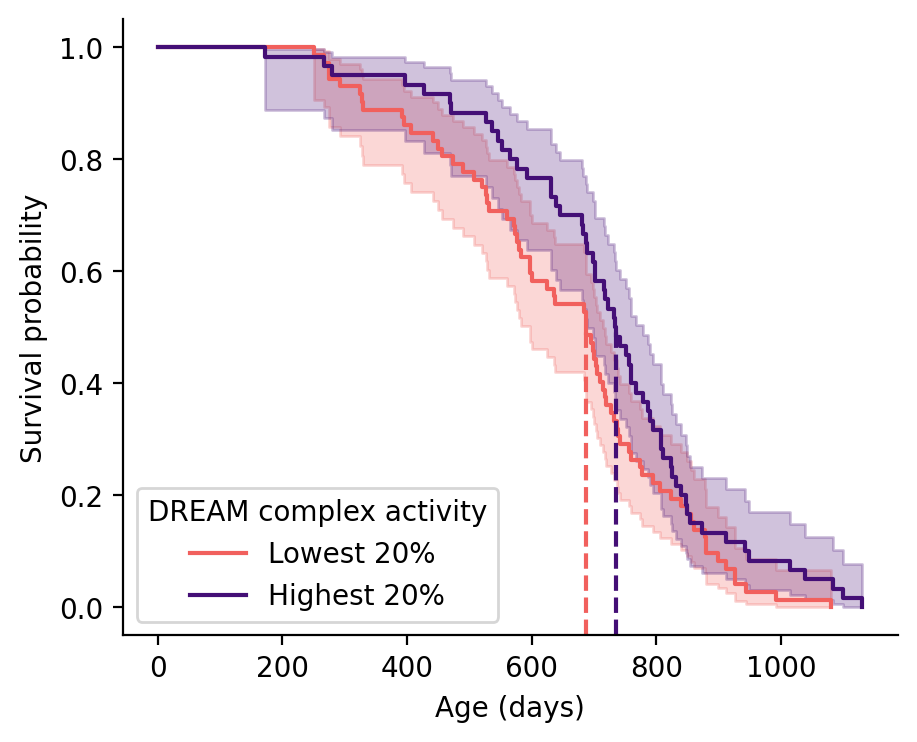

In [19]:
cd_surive_df = survive.query("Diet3 == 'CD'")
# bin DREAM in 5 bins
cd_surive_df['DREAM_bin'] = pd.qcut(cd_surive_df['DREAM_normalized_enrichment_score_resid'], 5, labels = ['Lowest 20%', 'Low-Mid', 'Mid', 'Mid-High', 'Highest 20%'])
# keep only most extreme bins
cd_surive_df = cd_surive_df.query('DREAM_bin in ["Lowest 20%", "Highest 20%"]')
# plot survival curves for each bin
fig, axes = plt.subplots(1, 1, figsize = (5, 4))
# get categorical colormap of magma
cmap = plt.get_cmap('magma')
# get colors
colors = cmap(np.linspace(0, 1, 10))
# keep only middle 5 colors
colors = colors[[6, 2]]
# create a dictionary of colors
color_dict = dict(zip(cd_surive_df['DREAM_bin'].unique(), colors))

median_survival = {}

for i, bin_val in enumerate(cd_surive_df['DREAM_bin'].unique()):
    mask = cd_surive_df['DREAM_bin'] == bin_val
    # Create a KaplanMeierFitter object
    this_strain_kmf = KaplanMeierFitter()
    this_strain_kmf.fit(
        durations = cd_surive_df['AgeAtDeath'][mask],
        event_observed = cd_surive_df['lifestatus'][mask], 
        label = bin_val
        )
    # plot survival curve without confidence intervals
    this_strain_kmf.plot(show_censors = False, ci_show = True,  ax = axes, alpha = 1, color = color_dict[bin_val])
    median_survival[bin_val] = this_strain_kmf.median_survival_time_
    
sns.despine()
# set axes labels
axes.set_xlabel("Age (days)")
axes.set_ylabel("Survival probability")
# name legend
axes.legend(title = "DREAM complex activity")
# draw a vertical dashed line at 50% survival for each bin
for bin_val in cd_surive_df['DREAM_bin'].unique():
    axes.axvline(median_survival[bin_val], linestyle = '--', color = color_dict[bin_val], ymax=0.5)
    
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/survival_curves_by_dream_cd.svg")
# print median survival time of each
print("Median survival time in lowest bin: ", median_survival['Lowest 20%'])
print("Median survival time in highest bin: ", median_survival['Highest 20%'])

from lifelines.statistics import logrank_test

results = logrank_test(
    cd_surive_df.query('DREAM_bin == "Lowest 20%"')['AgeAtDeath'],
    cd_surive_df.query('DREAM_bin == "Highest 20%"')['AgeAtDeath'],
    cd_surive_df.query('DREAM_bin == "Lowest 20%"')['lifestatus'],
    cd_surive_df.query('DREAM_bin == "Highest 20%"')['lifestatus'],
    alpha = 0.95
    )
print(results.summary)

# Predicting surivival delta (CD - HF)

In [75]:
lifespan = 'StrainMaxLifespan'

# count number of mice in each strain-diet group
count_mice = williams.dream_expression.groupby(['Strain3']).size().reset_index(name = 'count')
low_count = count_mice.query("count < 0")[['Strain3']]


# get the median lifespan within each strain-diet group, for strain-diets with >=3 mice and not in high_std
med_lf_by_strain_diet = williams.dream_expression.query("Strain3 not in @low_count['Strain3']").groupby(['Strain3', 'Diet3'])[lifespan].median().reset_index().dropna()


# pivot so HF and CD are in separate columns
med_lf_by_strain_diet_short = med_lf_by_strain_diet.pivot(index = 'Strain3', columns = 'Diet3', values = lifespan).reset_index() 
med_lf_by_strain_diet_short['HF_CD'] = med_lf_by_strain_diet_short['HF'] - med_lf_by_strain_diet_short['CD']

# get median DREAM within each strain-diet group
med_dream_by_strain_diet = williams.dream_expression.groupby(['Strain3', 'Diet3'])['DREAM_normalized_enrichment_score_resid'].median().reset_index().dropna()
# pivot so HF and CD are in separate columns
med_dream_by_strain_diet_short = med_dream_by_strain_diet.pivot(index = 'Strain3', columns = 'Diet3', values = 'DREAM_normalized_enrichment_score_resid').reset_index().dropna()
med_dream_by_strain_diet_short['HF_CD_dream'] = med_dream_by_strain_diet_short['HF'] - med_dream_by_strain_diet_short['CD']
# join with median lifespan on Strain3 and Diet3
med_dream_by_strain_diet = med_dream_by_strain_diet.merge(med_lf_by_strain_diet, on = ['Strain3', 'Diet3'], how = 'inner')

# merge med_dream_by_strain_diet_short and med_lf_by_strain_diet_short on Strain3, make suffix _dream
combined_short =  med_lf_by_strain_diet_short.merge(med_dream_by_strain_diet_short, on = 'Strain3', how = 'inner', suffixes = ('_lifespan', '_dream'))

# for pointplot
lf_dream_df =  med_lf_by_strain_diet_short.merge(williams.dream_expression.query("Diet3 == 'CD'"), on = 'Strain3', how = 'left')

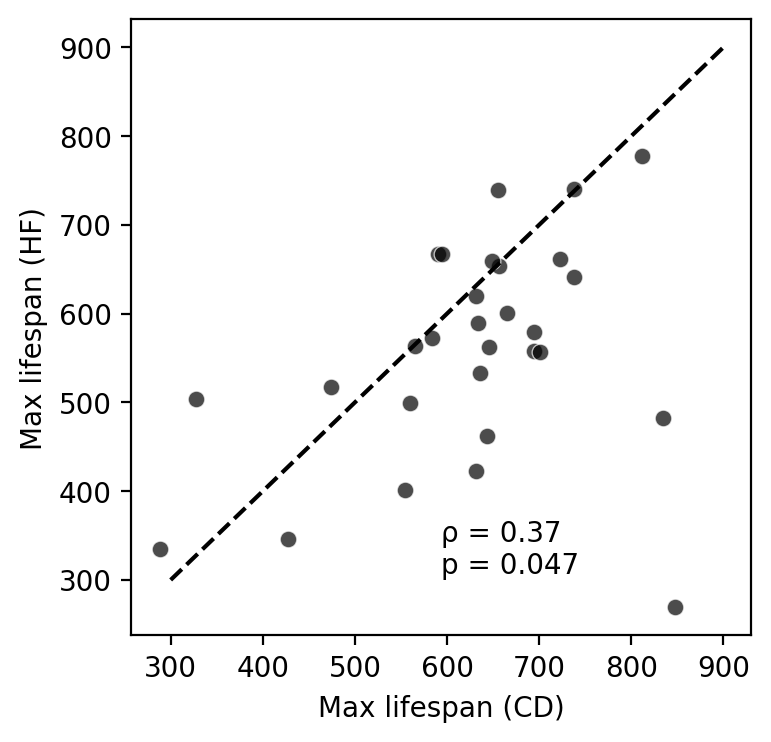

In [79]:
fig, axes = plt.subplots(1, 1, figsize = (4, 4))

sns.scatterplot(
    data = med_lf_by_strain_diet_short, x = 'CD', y = 'HF',
    ax = axes, color = 'black', alpha = 0.7
    )
axes.set_xlabel("Max lifespan (CD)")
axes.set_ylabel("Max lifespan (HF)")
# plot y = x line from 300 to 900
plt.plot([300, 900], [300, 900], color = 'black', linestyle = '--')
# add spearman correlation using rho symbol
r, p = spearmanr(med_lf_by_strain_diet_short.dropna()['CD'], med_lf_by_strain_diet_short.dropna()['HF'])
axes.text(0.5, 0.1, f"ρ = {r:.2f}\np = {p:.2}", transform=axes.transAxes)

# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/mouse_survival/max_lifespan_HF_vs_CD_scatter.svg")

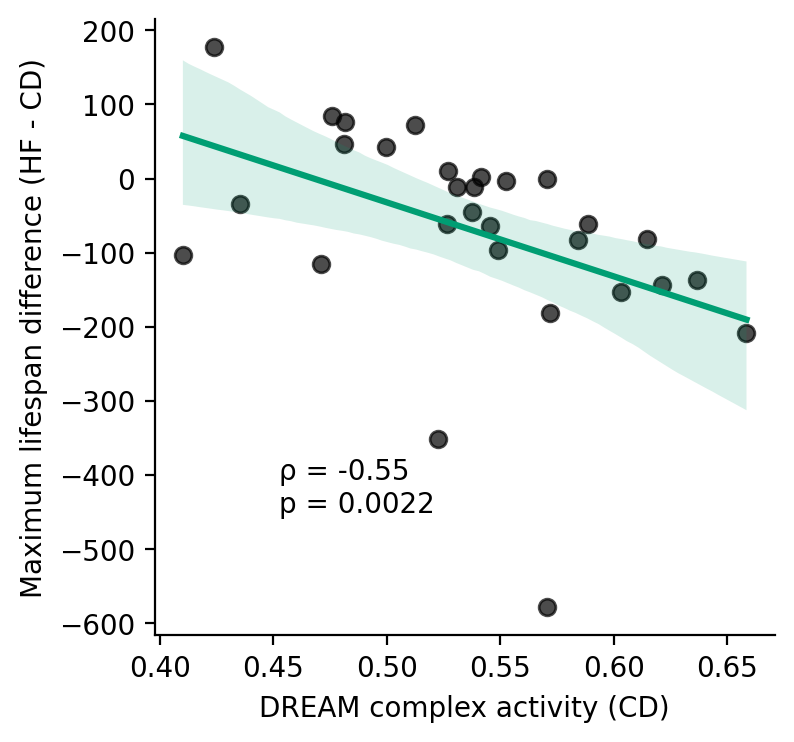

In [81]:
fig, axes = plt.subplots(1, 1, figsize = (4, 4))
# make points black
sns.regplot(
    data = combined_short, x = 'CD_dream', y = 'HF_CD',
    ax = axes, scatter_kws = {'color': 'black','alpha' : 0.7}, color = my_categorical_palette[0],
    )
axes.set_ylabel("Maximum lifespan difference (HF - CD)")
axes.set_xlabel("DREAM complex activity (CD)")
sns.despine()
# add spearman correlation to plot, using rho symbol
r, p = spearmanr(combined_short.dropna()['CD_dream'], combined_short.dropna()['HF_CD'])
axes.text(0.2, 0.2, f"ρ = {r:.2f}\np = {p:.2}", transform=axes.transAxes)
# save as svg
plt.savefig("/cellar/users/zkoch/dream/figures/fig_mouse_survival/max_lifespan_diff_vs_dream_scatter.svg")